In [1]:
# default_exp parse

# parse

> API details.

with help from: https://github.com/mtraver/python-fitanalysis/

In [4]:
#hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.utils import *

In [5]:
# export
from strava_overview.to_csv import *
import pandas as pd
import numpy as np

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [6]:
import seaborn as sns

In [7]:
f = '3076910670.csv'
df = pd.read_csv(f)
df.iloc[97:102,:]

,time,act_id,act_startDate,act_name,distance,latlng,altitude,velocity_smooth,moving,grade_smooth,temp,watts,cadence,heartrate
97,97,3076910670,2020-02-06 13:44:50+00:00,Middagritje,740.4,"[52.545855, 4.670854]",-0.4,7.5,True,0.0,15,175,92,130
98,98,3076910670,2020-02-06 13:44:50+00:00,Middagritje,747.6,"[52.545794, 4.670888]",-0.4,7.4,True,0.7,15,174,92,129
99,99,3076910670,2020-02-06 13:44:50+00:00,Middagritje,755.0,"[52.545742, 4.670961]",-0.4,7.3,True,1.3,15,138,94,128
100,100,3076910670,2020-02-06 13:44:50+00:00,Middagritje,762.9,"[52.545703, 4.671058]",-0.2,7.3,True,1.3,15,123,91,128
101,101,3076910670,2020-02-06 13:44:50+00:00,Middagritje,770.9,"[52.545668, 4.671161]",0.0,7.4,True,1.3,15,114,90,129


In [58]:
# export 
def interpolate(df):    
    df.index = df['time']
    df2 = df.reindex(np.arange(df.index[-1]))
    df2 = df2.interpolate()
    return df2

In [59]:
f = '3076910670.csv'
df2 = pd.read_csv(f)
df2 = df2.drop(100)
df2.iloc[97:102,:]

,time,act_id,act_startDate,act_name,distance,latlng,altitude,velocity_smooth,moving,grade_smooth,temp,watts,cadence,heartrate
97,97,3076910670,2020-02-06 13:44:50+00:00,Middagritje,740.4,"[52.545855, 4.670854]",-0.4,7.5,True,0.0,15,175,92,130
98,98,3076910670,2020-02-06 13:44:50+00:00,Middagritje,747.6,"[52.545794, 4.670888]",-0.4,7.4,True,0.7,15,174,92,129
99,99,3076910670,2020-02-06 13:44:50+00:00,Middagritje,755.0,"[52.545742, 4.670961]",-0.4,7.3,True,1.3,15,138,94,128
101,101,3076910670,2020-02-06 13:44:50+00:00,Middagritje,770.9,"[52.545668, 4.671161]",0.0,7.4,True,1.3,15,114,90,129
102,102,3076910670,2020-02-06 13:44:50+00:00,Middagritje,778.8,"[52.545637, 4.671266]",0.0,7.7,True,1.3,15,116,91,129


In [63]:
df2 = interpolate(df2)
test_eq(df2['velocity_smooth'].iloc[100],7.35)
df2.iloc[97:102,:]

,time,act_id,act_startDate,act_name,distance,latlng,altitude,velocity_smooth,moving,grade_smooth,temp,watts,cadence,heartrate
time,,,,,,,,,,,,,,
97.0,97.0,3.076911e+09,2020-02-06 13:44:50+00:00,Middagritje,740.40,"[52.545855, 4.670854]",-0.4,7.50,True,0.0,15.0,175.0,92.0,130.0
98.0,98.0,3.076911e+09,2020-02-06 13:44:50+00:00,Middagritje,747.60,"[52.545794, 4.670888]",-0.4,7.40,True,0.7,15.0,174.0,92.0,129.0
99.0,99.0,3.076911e+09,2020-02-06 13:44:50+00:00,Middagritje,755.00,"[52.545742, 4.670961]",-0.4,7.30,True,1.3,15.0,138.0,94.0,128.0
100.0,100.0,3.076911e+09,NaN,NaN,762.95,NaN,-0.2,7.35,NaN,1.3,15.0,126.0,92.0,128.5
101.0,101.0,3.076911e+09,2020-02-06 13:44:50+00:00,Middagritje,770.90,"[52.545668, 4.671161]",0.0,7.40,True,1.3,15.0,114.0,90.0,129.0


In [8]:
# export
def moving_average(time_series, window_len):
    """Calculates the moving average of an unevenly spaced time series.

    This moving average implementation weights each value by the time it remained
    unchanged, which conceptually matches smart recording on GPS devices: a sample
    is taken when some value changes sufficiently, so before a new sample is taken
    the previous one is assumed to be more or less constant.

    The term "area" below means a sum of time-weighted values.

    This implementation follows the SMA_last algorithm proposed
    in (Eckner, 2017) (see README for citation).

    Args:
    time_series: A pandas.Series of the values to average,
                 indexed with timestamps.
    window_len: The size of the moving average window, in seconds.

    Returns:
    A numpy array of length len(time_series) containing the
    moving average values
    """
    # Re-index the time series with duration in seconds from the first value
#     time_series.index = (
#       (time_series.index
#        - time_series.index[0]) / np.timedelta64(1, 's')).astype('int')

    window_area = time_series.iloc[0] * window_len

    # It may not always be possible to construct a window of length exactly equal
    # to window_len using timestamps present in the data. To handle this, the left
    # side of the window is allowed to fall between timestamps (the right side is
    # always fixed to a timestamp in the data). Therefore we need to separately
    # compute the area of the inter-timestamp region on the left side of the
    # window so that it can be added to the window area. left_area is that value.
    left_area = window_area

    out = np.zeros(len(time_series))
    out[0] = time_series.iloc[0]

    # i is the left side of the window and j is the right
    i = 0
    for j in range(1, len(time_series)):
        # Remove the last iteration's left_area as a new right window bound may
        # change the left_area required in this iteration
        window_area -= left_area

        # Expand window to the right
        window_area += time_series.iloc[j-1] * (time_series.index[j]
                                                - time_series.index[j-1])

        # Shrink window from the left if expanding to the right has created too
        # large a window. new_left_time may fall between timestamps present in the
        # data, which is fine, since that's handled by left_area.
        new_left_time = time_series.index[j] - window_len
        while time_series.index[i] < new_left_time:
            window_area -= time_series.iloc[i] * (time_series.index[i+1]
                                                - time_series.index[i])
            i += 1

        # Add left side inter-timestamp area to window
        left_area = time_series.iloc[max(0, i - 1)] * (time_series.index[i]
                                                       - new_left_time)
        window_area += left_area

        out[j] = window_area / window_len

    return out

In [9]:
def norm_power(p):
    return np.sqrt(np.sqrt(np.mean(moving_average(p, 30) ** 4)))

In [10]:
df.index = df['time'].astype('float')
test_close(norm_power(df.watts),207,1)

In [11]:
test_close(norm_power(df.heartrate),134,1)

In [12]:
# export
def training_impulse(norm_p, total_time, ftp):
    intesity = norm_p/float(ftp)
    return (total_time*norm_p * intesity)/(float(ftp)*3600.) *100
    

In [13]:
df.index = df['time'].astype('float')
test_close(norm_power(df.watts),207,1)
training_impulse(norm_power(df.watts), sum(df['moving']), 340)

61.0680736825466

In [146]:
# export
class Zones():
    def __init__(self,max_hr, zones = [.6,.7,.79,.85,.9, 1]):
        self.zones, self.max_hr = zones, max_hr
        
    def __repr__(self,):
        res = {}
        for k,start,end in zip(range(1,6),self.zones[:-1],self.zones[1:]):
            res[k] = (start*self.max_hr,end*self.max_hr)
        return str(res)
    
    def __str__(self):
        return self.__repr__()
    
    def __call__(self, o):
        for i, v in enumerate(self.zones):
            if o < v*self.max_hr:
                return i       
    

In [152]:
z =Zones(195)
test_eq(str(z),str({1: (117.0, 136.5), 2: (136.5, 154.05), 3: (154.05, 165.75), 4: (165.75, 175.5), 5: (175.5, 195)} ))
test_eq(z(175),4)

In [160]:
# export
def training_impulse_hr(hr, max_hr):
    z = Zones(max_hr)
    norm_hr = pd.Series((moving_average(hr, 15))).apply(z)
    norm_hr.plot()
    return (np.sum(norm_hr) ) / (4*3600)*100

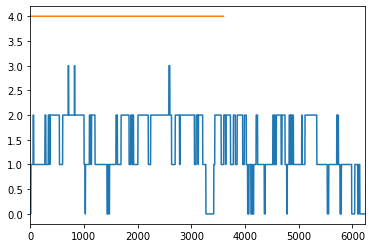

In [161]:
test_close(training_impulse_hr(df.heartrate, 195),60, 1)
test_eq(training_impulse_hr(pd.Series([175]*3600), 195),100)

In [162]:
# export
def parse_tss(df, threshold = 179, ftp = 339):
    df.index = df['time']
    df.reindex(np.arange(df.index[-1]))
    if 'watts' in list(df.columns):
        df['ftp'] = df['watts']
        print('watts')
    elif 'heartrate' in list(df.columns):
        df['ftp'] = (df['heartrate'])/ (threshold)
    else:
        print(df.columns)
    return df


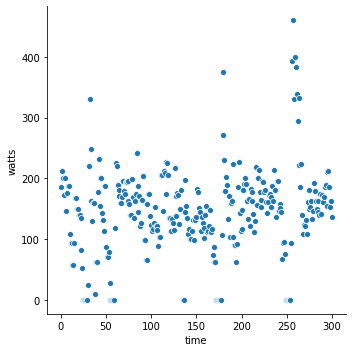

In [27]:
sns.relplot(x='time',y='watts',data = df.iloc[:300])

In [5]:
# df = pd.read_csv(fs[3])
import numpy as np
df = pd.DataFrame({'watts':[339]*3600, 'time': np.arange(3600)})
df = parse_tss(df)
test_close(df['ftp'].mean()* (df.loc[:, 'time'].iloc[-1]/60/60)*100,100,0.3)

NameError: name 'pd' is not defined

In [216]:
df = pd.DataFrame({'heartrate':[179]*3600, 'time': np.arange(3600)})
df = parse_tss(df)
test_close(df['ftp'].mean()* (df.loc[:,'time'].iloc[-1]/60/60)*100,100,0.3)

In [217]:
df = pd.read_csv(f)
df = parse_tss(df)
(df['ftp'].mean()*340, (df.loc[:,'time'].iloc[-1]/60/60)*100,110,1)

watts


(188.38387451817655, 173.16666666666666, 110, 1)

In [203]:
import seaborn as sns

In [204]:
df['diff'] = df['time'] - df['time'].shift(-1)

In [205]:
sns.distplot('diff', data=df)

TypeError: distplot() got an unexpected keyword argument 'data'

132.4288327844859


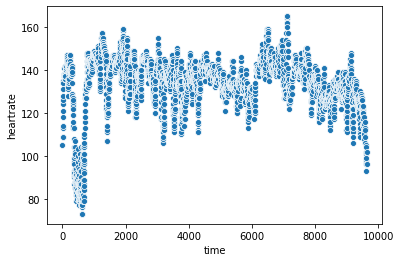

In [206]:

df.index = df['time']
df2 = df.reindex(np.arange(df.index[-1]))
df2.interpolate()
print(df2['heartrate'].mean())
sns.scatterplot(x='time',y='heartrate',data = df2)

In [209]:

df = parse_tss(df)
(df['ftp'].mean(), (df.loc[:,'time'].iloc[-1]/60/60),110,1)

(0.7397494002689083, 2.6758333333333337, 110, 1)

In [ ]:

    #Calculate the timestamp column
    df_total = df_total.reset_index(level=0)
    df_total['timestamp'] = pd.to_datetime(map(calctime, df_total['time'], df_total['level_0'])).to_pydatetime()

    #Split out lat and long columns
    df_total['lat'] = map(split_lat, (df_total['latlng']))
    df_total['long'] = map(split_long, (df_total['latlng']))

    #Index by startdate and timestamp, and drop arbitrary columns
    df_total = df_total.set_index(['act_startDate','timestamp'])
    df_total.drop(['latlng', 'level_0'], axis=1, inplace=True)

    print ('script complete!')